# DT8122 - Assignment

<span style="color:red">Deadline: 2023 August 15 AoE (Anywhere on Earth)</span>

Send a zip file with the notebook both as a .ipynb and as a .pdf file to <a href="mailto:dt8122@idi.ntnu.no">dt8122@idi.ntnu.no</a>. Label the file with your full name.

The task is to implement conditional DDPM for MNIST images. Your implementation should take as input a digit and be able to generate 28x28 grayscale handwritten image of said digit. 

You can add additional cells anywhere in the notebook to make your code more readable.

DDPM: https://arxiv.org/abs/2006.11239

Classifier-free conditional DDPM: https://arxiv.org/abs/2207.12598

The notebook should be run when it is turned in so all plots are visible. All code should be contained in the notebook.


### Install necessary libraries
Any additional libraries you make use of should be installed in this cell.

### Import libraries
All import statements should be contained here.

In [2]:
import random
import math

import matplotlib.pyplot as plt
import torch

from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST

from typing import Optional, Tuple, TypeVar
import numpy as np
from tqdm import tqdm

### Define constants here
Constants such as number of epochs, device, and learning rate and other hyperparameters should be defined here.

In [30]:
SEED = 1
random.seed(SEED)
torch.manual_seed(SEED)

batch_size = 256
##number of steps for defusion and denoising
N = 400
BMIN = 0.0001
BMAX = 0.02
guidence_w = 0.5
device = "cuda:0"


### Functionality for loading and visualizing dataset
We have provided some functionality for loading and visualizing the dataset. You may add more cells/functions here.

In [4]:
## from 0-1 to -1-1
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [5]:
"""
This function plots images in a grid. Input is a Tensor.
See show_first_batch to see how it is used.
"""
def show_images(images, title=""):
    images = images.detach().cpu().numpy()
    fig = plt.figure(figsize=(4, 4))
    cols = math.ceil(len(images) ** (1 / 2))
    rows = math.ceil(len(images) / cols)
    for r in range(rows):
        for c in range(cols):
            idx = cols * r + c
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.axis('off')
            if idx < len(images):
                ax.imshow(images[idx][0], cmap="gray")
    fig.suptitle(title, fontsize=18)
    plt.show()

tensor([4, 8, 8, 6, 7, 1, 0, 7, 1, 8, 7, 6, 4, 9, 1, 5, 3, 2, 6, 8, 8, 6, 9, 4,
        6, 0, 4, 2, 6, 7, 0, 5, 8, 6, 0, 3, 5, 7, 4, 7, 5, 1, 6, 7, 3, 6, 0, 3,
        1, 1, 2, 6, 7, 9, 8, 0, 7, 2, 4, 3, 6, 5, 9, 5, 2, 3, 5, 3, 5, 8, 9, 2,
        7, 1, 2, 4, 0, 2, 0, 6, 7, 2, 9, 5, 7, 1, 2, 2, 3, 3, 8, 8, 1, 0, 5, 7,
        5, 9, 6, 7, 2, 5, 9, 7, 5, 7, 1, 7, 8, 7, 8, 8, 8, 2, 1, 4, 1, 1, 3, 2,
        9, 5, 1, 9, 0, 3, 0, 3, 4, 8, 4, 8, 5, 3, 7, 2, 9, 2, 7, 6, 3, 3, 0, 1,
        4, 6, 4, 4, 6, 6, 7, 3, 5, 8, 3, 6, 6, 2, 0, 5, 2, 3, 7, 9, 9, 3, 5, 1,
        1, 5, 4, 7, 4, 4, 6, 6, 5, 3, 0, 9, 1, 1, 2, 4, 1, 0, 8, 7, 7, 0, 3, 7,
        4, 9, 4, 8, 6, 0, 1, 8, 7, 7, 6, 5, 7, 0, 1, 7, 3, 2, 3, 4, 8, 5, 2, 4,
        6, 8, 7, 8, 5, 1, 0, 2, 0, 6, 2, 3, 5, 7, 6, 3, 5, 7, 8, 4, 2, 8, 0, 7,
        4, 3, 8, 5, 1, 5, 4, 0, 4, 1, 9, 3, 3, 1, 7, 6, 8, 7, 3, 6, 3, 3, 2, 6,
        8, 1, 2, 3, 6, 2, 1, 7, 2, 4, 6, 0, 1, 9, 0, 7, 7, 7, 2, 3, 8, 3, 0, 7,
        4, 9, 0, 6, 3, 9, 1, 2, 0, 1, 7,

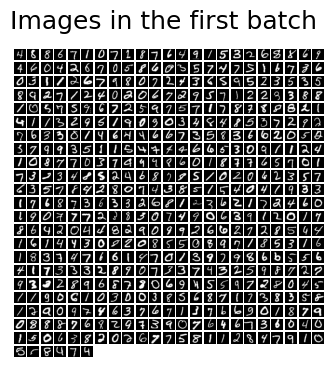

In [6]:
def show_first_batch(loader):
    for batch_feats,batch_labels in loader:
        print(batch_labels)
        print(batch_feats.shape)
        show_images(batch_feats, "Images in the first batch")
        break
show_first_batch(loader)

### Your conditional DDPM implementation should go here
This includes functionality for adding noise to the image.

In [7]:
class Forward_pass:
    def __init__(self) -> None:
        #number of steps
        self.N = N
        self.beta_min = BMIN
        self.beta_max = BMAX
        self._betas, self._alphas, self._alpha_bars = (0, 0 ,0)
        self.get_coefs()
    
    ##linear steps     
    def get_coefs(self):
        """Get the coefficients for the noise schedule.
        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]: 
                betas, alphas, alpha_bars
        """        
        self._betas = torch.linspace(self.beta_min, self.beta_max, self.N)
        self._alphas = 1 - self._betas
        self._alpha_bars = torch.cumprod(self._alphas, dim=0)

    #return the coef for initializing the denoising model
    def ret_coefs(self) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:

        return (self._betas,self._alphas,self._alpha_bars) 
   
    def _q_mean(
        self,
        z: torch.FloatTensor,
        t: torch.LongTensor,
    ) -> torch.FloatTensor:
        # mean of the distribution q(z_t | z_0)
        sqrt_alpha_bars = torch.sqrt(self._alpha_bars[t.tolist()])
        return sqrt_alpha_bars.view(-1,1,1,1) * z

    def _q_std(
        self,
        z: torch.FloatTensor,
        t: torch.LongTensor,
    ) -> torch.FloatTensor:
        # std of the distribution q(z_t | z_0)
        std = torch.sqrt(1.0 - self._alpha_bars[t.tolist()])
        return std.view(-1,1,1,1)

    def q_sample(
        self,
        z: torch.FloatTensor,
        t: torch.LongTensor,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        # Sample from q(z_t | z_0)

        mean = self._q_mean(z, t)
        std = self._q_std(z, t)
        epsilon = torch.randn_like(z)
        z_t = epsilon * std + mean

        return z_t, epsilon
    
    ##for training, sample random n timesteps for each input, return the repeated features, times-steps sampled and the episilons
    def q_sample_random(
        self,
        z: torch.FloatTensor,
        lables: torch.FloatTensor,
        n_timesteps = 5,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor,  torch.FloatTensor]:
        # Sample from q(z_t | z_0)
        #we use the same times steps for all the samples in this batch for simplicity
        times = list(torch.randint(0, self.N-1, (n_timesteps,)))
        print(times)
        times_list = [torch.Tensor([i]).repeat(z.shape[0]).to(torch.int64) for i in times ]
        times_repeated = torch.cat(times_list)
        lables_repeated = lables.repeat(n_timesteps)
        z_repeated = z.repeat(n_timesteps,1,1,1) #shape=(batch_size*5, 1, 28, 28)
        mean = self._q_mean(z_repeated, times_repeated)  #shape=(batch_size, 1, 28, 28)
        std = self._q_std(z_repeated, times_repeated)
        epsilon = torch.randn_like(z_repeated)
        
        z_out = epsilon * std + mean

        return z_out, epsilon, times_repeated, lables_repeated
    
    
    ##for training, sample randomly one timestep for each img, return the repeated features, times-steps sampled and the episilons
    def q_sample_random2(
        self,
        z: torch.FloatTensor,
        lables: torch.FloatTensor,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor,   torch.IntTensor, torch.IntTensor]:
        # Sample from q(z_t | z_0)
        #we use the same times steps for all the samples in this batch for simplicity
        times = torch.randint(0, self.N-1, (z.shape[0],))
        mean = self._q_mean(z, times)  #shape=(batch_size, 1, 28, 28)
        std = self._q_std(z, times)
        epsilon = torch.randn_like(z)
        
        z_out = epsilon * std + mean

        return z_out, epsilon, times, lables
    
    ##only sample t not the lable
    def q_sample_random_unconditional(
        self,
        z: torch.FloatTensor,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor,  torch.IntTensor]:
        # Sample from q(z_t | z_0)
        #we use the same times steps for all the samples in this batch for simplicity
        times = torch.randint(0, self.N-1, (z.shape[0],))
        mean = self._q_mean(z, times)  #shape=(batch_size, 1, 28, 28)
        std = self._q_std(z, times)
        epsilon = torch.randn_like(z)
        
        z_out = epsilon * std + mean

        return z_out, epsilon, times

### The implementation of the neural network used to estimate the noise should go here
The network should make use of both time and context embedding.

Any functions/methods used for time and context embeddings should also go here.

In [1]:
## we use only simple residual-CNN as the backbone models (copied from https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py)
class ResidualConvBlock(torch.nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.GELU(),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class UnetDown(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), torch.nn.MaxPool2d(2)]
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            torch.nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x
  
class EmbedFC(torch.nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            torch.nn.Linear(input_dim, emb_dim),
            torch.nn.GELU(),
            torch.nn.Linear(emb_dim, emb_dim),
        ]
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)
      
class UnconditionedBackbone(torch.nn.Module):
    def __init__(self, in_channels = 1, hidden_channels = 128, image_size = 28, num_timesteps=N) -> None:
        super(UnconditionedBackbone, self).__init__()

        self.in_channels = in_channels
        self.n_feat = hidden_channels
        self.image_size = image_size
        self.num_timesteps = num_timesteps

        self.init_conv = ResidualConvBlock(in_channels, self.n_feat, is_res=True)

        self.down1 = UnetDown(self.n_feat, self.n_feat)
        self.down2 = UnetDown(self.n_feat, 2 * self.n_feat)

        self.to_vec = torch.nn.Sequential(torch.nn.AvgPool2d(7), torch.nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*self.n_feat)
        self.timeembed2 = EmbedFC(1, 1*self.n_feat)
        
        self.up0 = torch.nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            torch.nn.ConvTranspose2d(2 * self.n_feat, 2 * self.n_feat, 7, 7), # otherwise just have 2*n_feat
            torch.nn.GroupNorm(8, 2 * self.n_feat),
            torch.nn.ReLU(),
        )

        self.up1 = UnetUp(4 * self.n_feat, self.n_feat)
        self.up2 = UnetUp(2 * self.n_feat, self.n_feat)
        self.out = torch.nn.Sequential(
            torch.nn.Conv2d(2 * self.n_feat, self.n_feat, 3, 1, 1),
            torch.nn.GroupNorm(8, self.n_feat),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.n_feat, self.in_channels, 3, 1, 1),
        )

        
    def forward(self, x, t) -> float:
        # x is (noisy) image batch (from the Forward_pass for training and from the N(0,1) for sampling),  (batch_size, channel(1), 28, 28)
        # diff_noise are the corresponding noise in the forward pass, 
        #labels are the numbers from 0-10, 10 represents the unconditioned sample, t is the timestep usually from 0-999, 

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)
        
        #embeddings 
        temb1 = self.timeembed1(t.type(torch.float32)).view(-1, self.n_feat * 2, 1, 1)
        temb2 = self.timeembed2(t.type(torch.float32)).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(up2 + temb2, down1)
        e_pred = self.out(torch.cat((up3, x), 1))

        return e_pred
    
class Reverse_pass(torch.nn.Module):
    def __init__(self, model, alphas, alpha_bars, betas, num_classes = 11 ) -> None:
        super().__init__()
        self.model = model
        #self.model.to(device)
        self.N = N
        self.num_classes = num_classes
        ##for computing the samples
        self.alphas = alphas
        self.sqrt_1_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        ##we use the simpler version of sigma for the reverse pass
        self.sigmas = torch.sqrt(betas) 
        self.guidence_w = guidence_w
        
        #loss
        self.mse = torch.nn.MSELoss()
        
    def sample(self, n_samples = 3, image_size = 28): 
        ## sample "n" samples for each number “0-9” (including the unditional label "10") using 'Classifier-Free Diffusion Guidance'
        with torch.no_grad():
            #sample noised images and arrange labels
            batch_size = n_samples*self.num_classes
            #x_batch = torch.randn(batch_size, 1, image_size, image_size).to(device)
            x_batch = torch.randn(batch_size, 1, image_size, image_size)
            ##labels = [0,0,0,1,1,1,2,2,2....]  
            labels = [ torch.tensor([i]).repeat(n_samples) for i in range(self.num_classes)]
            #labels = torch.cat(labels).to(device)
            labels = torch.cat(labels)
            # unconditioned labels for interpolation (label = 10)
            labels_uncon = torch.full_like(labels, self.num_classes-1)
            labels = torch.cat((labels, labels_uncon))
            last_batch = x_batch
            for i in range(self.N, 0, -1):
                print(f'sampling timestep {i}\n')
                #current_t = torch.tensor([i]).to(device)
                current_t = torch.tensor([i-1])  #i-1 for one-hot encoding
                t_batch = current_t.repeat(batch_size) #(batch_size)

                # duplicate the current img for unconditioned sampling
                x_doubled = last_batch.repeat(2,1,1,1) #(2*batch_size, channel, img_size, img_size)
                t_doubled = t_batch.repeat(2) #(2*batch_size)

                # predict the diffusion noise, and interpolate
                diff_noise = self.model(x_doubled, labels, t_doubled)
                diff_con = diff_noise[:batch_size]
                diff_uncon = diff_noise[batch_size:]
                diff_noise_final = (1+self.guidence_w)*diff_con - self.guidence_w*diff_uncon
                # predict x_t-1
                #observation_noise = torch.randn(batch_size, 1, image_size, image_size).to(device) if i > 1 else 0
                observation_noise = torch.randn(batch_size, 1, image_size, image_size) if i > 1 else 0
                x_predict = (1/torch.sqrt(self.alphas[i-1])) * (last_batch - diff_noise_final * (1 - self.alphas[i-1]) / self.sqrt_1_minus_alpha_bars[i-1]) + self.sigmas[i-1] * observation_noise
                
                last_batch = x_predict
            return last_batch
    
    def compute_loss(self, batch_input, batch_noise, batch_time, batch_lables):
        #a batch of diffused input (by the forward process), with its difuusion noise,  timesteps and labels as input
        # return the loss of this batch for training the model
        
        predicted_noise = self.model(batch_input, batch_lables, batch_time)
        return self.mse(batch_noise, predicted_noise)
    
    
    
class Reverse_pass_unconditional(torch.nn.Module):
    def __init__(self, model, alphas, alpha_bars, betas) -> None:
        super().__init__()
        self.model = model
        self.model.to(device)
        self.N = N
        ##for computing the samples
        self.alphas = alphas
        self.sqrt_1_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        ##we use the simpler version of sigma for the reverse pass
        self.sigmas = torch.sqrt(betas)      
        #loss
        self.mse = torch.nn.MSELoss()
        
    def sample(self, n_samples = 10, image_size = 28): 
        ## sample "n" samples for each number “0-9” (including the unditional label "10") using 'Classifier-Free Diffusion Guidance'
        with torch.no_grad():
            #sample noised images and arrange labels
            batch_size = n_samples
            x_batch = torch.randn(batch_size, 1, image_size, image_size).to(device)
            for i in range(self.N, 0, -1):
                print(f'sampling timestep {i}\n')
                current_t = torch.tensor([i-1])  #i-1 for one-hot encoding
                t_batch = current_t.repeat(batch_size).to(device) #(batch_size)

                # predict the diffusion noise, and interpolate
                diff_noise = self.model(x_batch,  t_batch)
                diff_noise_final = diff_noise
                # predict x_t-1
                #observation_noise = torch.randn(batch_size, 1, image_size, image_size).to(device) if i > 1 else 0
                observation_noise = torch.randn(batch_size, 1, image_size, image_size, device=device) if i > 1 else 0
                x_batch = (1/torch.sqrt(self.alphas[i-1])) * (x_batch - diff_noise_final * (1 - self.alphas[i-1]) / self.sqrt_1_minus_alpha_bars[i-1]) + self.sigmas[i-1] * observation_noise           
    
            return x_batch
    
    def compute_loss(self, batch_input, batch_noise, batch_time):
        #a batch of diffused input (by the forward process), with its difuusion noise,  timesteps and labels as input
        # return the loss of this batch for training the model
        
        predicted_noise = self.model(batch_input.to(device), batch_time.to(device))
        return self.mse(batch_noise.to(device), predicted_noise)

NameError: name 'torch' is not defined

### Show that you can generate images before the model is trained
This should demonstrate that the backwards pass works. The generated images are expected to be noise.

sampling timestep 400

sampling timestep 399

sampling timestep 398

sampling timestep 397

sampling timestep 396

sampling timestep 395

sampling timestep 394

sampling timestep 393

sampling timestep 392

sampling timestep 391

sampling timestep 390

sampling timestep 389

sampling timestep 388

sampling timestep 387

sampling timestep 386

sampling timestep 385

sampling timestep 384

sampling timestep 383

sampling timestep 382

sampling timestep 381

sampling timestep 380

sampling timestep 379

sampling timestep 378

sampling timestep 377

sampling timestep 376

sampling timestep 375

sampling timestep 374

sampling timestep 373

sampling timestep 372

sampling timestep 371

sampling timestep 370

sampling timestep 369

sampling timestep 368

sampling timestep 367

sampling timestep 366

sampling timestep 365

sampling timestep 364

sampling timestep 363

sampling timestep 362

sampling timestep 361

sampling timestep 360

sampling timestep 359

sampling timestep 358

sampling ti

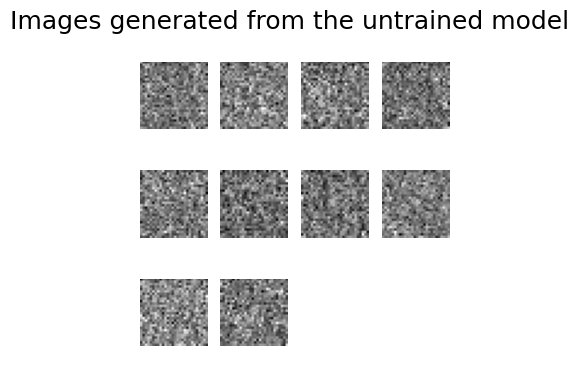

In [35]:
model = UnconditionedBackbone()
forward = Forward_pass()
betas,alphas,alpha_bars = forward.ret_coefs()
reverse = Reverse_pass_unconditional(model, alphas, alpha_bars, betas)
return_batch = reverse.sample()
show_images(return_batch, "Images generated from the untrained model")


### Implement training loop
Train the model here. There should be some indication of how long the model took to train, both total and per epoch. For good results you will want to train the model for several epochs, but with a good implementation you should expect to see something that looks like digits after only a single epoch.

In [36]:
def train_conditionedDDPM(n_epochs = 10, learning_rate = 0.0001):
    print(f"{sum(p.numel() for p in reverse.parameters() if p.requires_grad)} parameters to train")
    optimizer = torch.optim.Adam(reverse.parameters(), lr=learning_rate)
    for i in range(n_epochs):
        print(f"Training epoch: {i+1}")
        progress_loader = tqdm(loader)
        for batch_feats,batch_labels in progress_loader:
            optimizer.zero_grad()
            #sample with forward pass
            #z_out, epsilon_target, times, labels= forward.q_sample_random(batch_feats, batch_labels)
            z_out, epsilon_target, times, labels= forward.q_sample_random2(batch_feats, batch_labels)
            loss = reverse.compute_loss(z_out, epsilon_target, times, labels)
            loss.backward()
            optimizer.step()
            
def train_unconditionedDDPM(n_epochs = 20, learning_rate = 0.0001):
    print(f"{sum(p.numel() for p in reverse.parameters() if p.requires_grad)} parameters to train")
    optimizer = torch.optim.Adam(reverse.parameters(), lr=learning_rate)
    for i in range(n_epochs):
        print(f"Training epoch: {i+1}")
        progress_loader = tqdm(loader)
        total_loss = 0 
        for batch_feats,batch_labels in progress_loader:
            optimizer.zero_grad()
            #sample with forward pass
            #z_out, epsilon_target, times, labels= forward.q_sample_random(batch_feats, batch_labels)
            z_out, epsilon_target, times = forward.q_sample_random_unconditional(batch_feats)
            loss = reverse.compute_loss(z_out, epsilon_target, times)
            total_loss += loss
            loss.backward()
            optimizer.step()
        
        print(f'Loss for the current epoch is {total_loss}')
            

### Train and visualize the model
We want to see several generated examples of each digit.

In [37]:
model = UnconditionedBackbone()
forward = Forward_pass()
betas,alphas,alpha_bars = forward.ret_coefs()
reverse = Reverse_pass_unconditional(model, alphas, alpha_bars, betas)
train_unconditionedDDPM()

6499073 parameters to train
Training epoch: 1


100%|██████████| 118/118 [00:25<00:00,  4.67it/s]


Loss for the current epoch is 21.45106315612793
Training epoch: 2


100%|██████████| 118/118 [00:25<00:00,  4.61it/s]


Loss for the current epoch is 10.282073974609375
Training epoch: 3


100%|██████████| 118/118 [00:26<00:00,  4.53it/s]


Loss for the current epoch is 8.386003494262695
Training epoch: 4


100%|██████████| 118/118 [00:26<00:00,  4.44it/s]


Loss for the current epoch is 7.527139663696289
Training epoch: 5


100%|██████████| 118/118 [00:28<00:00,  4.18it/s]


Loss for the current epoch is 7.102622032165527
Training epoch: 6


100%|██████████| 118/118 [00:29<00:00,  4.06it/s]


Loss for the current epoch is 6.700626373291016
Training epoch: 7


100%|██████████| 118/118 [00:29<00:00,  4.04it/s]


Loss for the current epoch is 6.314161777496338
Training epoch: 8


100%|██████████| 118/118 [00:27<00:00,  4.33it/s]


Loss for the current epoch is 6.177925109863281
Training epoch: 9


100%|██████████| 118/118 [00:26<00:00,  4.48it/s]


Loss for the current epoch is 6.062160015106201
Training epoch: 10


100%|██████████| 118/118 [00:26<00:00,  4.50it/s]


Loss for the current epoch is 5.9576640129089355
Training epoch: 11


100%|██████████| 118/118 [00:26<00:00,  4.53it/s]


Loss for the current epoch is 5.7550883293151855
Training epoch: 12


100%|██████████| 118/118 [00:26<00:00,  4.53it/s]


Loss for the current epoch is 5.615904808044434
Training epoch: 13


100%|██████████| 118/118 [00:26<00:00,  4.51it/s]


Loss for the current epoch is 5.4954023361206055
Training epoch: 14


100%|██████████| 118/118 [00:26<00:00,  4.45it/s]


Loss for the current epoch is 5.464383125305176
Training epoch: 15


100%|██████████| 118/118 [00:27<00:00,  4.32it/s]


Loss for the current epoch is 5.343893051147461
Training epoch: 16


100%|██████████| 118/118 [00:26<00:00,  4.37it/s]


Loss for the current epoch is 5.356856822967529
Training epoch: 17


100%|██████████| 118/118 [00:26<00:00,  4.47it/s]


Loss for the current epoch is 5.242405891418457
Training epoch: 18


100%|██████████| 118/118 [00:26<00:00,  4.50it/s]


Loss for the current epoch is 5.227744102478027
Training epoch: 19


100%|██████████| 118/118 [00:26<00:00,  4.51it/s]


Loss for the current epoch is 5.055746555328369
Training epoch: 20


100%|██████████| 118/118 [00:26<00:00,  4.52it/s]

Loss for the current epoch is 5.085348606109619


sampling timestep 400

sampling timestep 399

sampling timestep 398

sampling timestep 397

sampling timestep 396

sampling timestep 395

sampling timestep 394

sampling timestep 393

sampling timestep 392

sampling timestep 391

sampling timestep 390

sampling timestep 389

sampling timestep 388

sampling timestep 387

sampling timestep 386

sampling timestep 385

sampling timestep 384

sampling timestep 383

sampling timestep 382

sampling timestep 381

sampling timestep 380

sampling timestep 379

sampling timestep 378

sampling timestep 377

sampling timestep 376

sampling timestep 375

sampling timestep 374

sampling timestep 373

sampling timestep 372

sampling timestep 371

sampling timestep 370

sampling timestep 369

sampling timestep 368

sampling timestep 367

sampling timestep 366

sampling timestep 365

sampling timestep 364

sampling timestep 363

sampling timestep 362

sampling timestep 361

sampling timestep 360

sampling timestep 359

sampling timestep 358

sampling ti

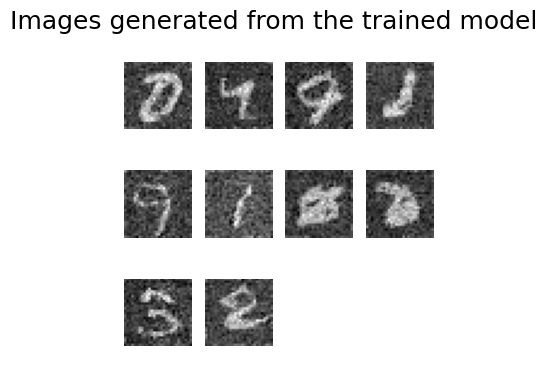

In [41]:
return_batch = reverse.sample()
show_images(return_batch, "Images generated from the trained model")

In [40]:
return_batch[0]



tensor([[[-0.2044, -0.3010, -0.2953, -0.2903, -0.2733, -0.2609, -0.2816,
          -0.2756, -0.2797, -0.3068, -0.2946, -0.2331, -0.2001, -0.3443,
          -0.3165, -0.3063, -0.2904, -0.2956, -0.2188, -0.3589, -0.2512,
          -0.3154, -0.3027, -0.3096, -0.2283, -0.3322, -0.3139, -0.3147],
         [-0.3726, -0.2626, -0.3130, -0.2966, -0.3716, -0.3361, -0.2631,
          -0.2770, -0.2917, -0.2582, -0.3003, -0.3187, -0.2558, -0.3456,
          -0.2845, -0.2210, -0.3128, -0.3540, -0.3070, -0.3933, -0.2887,
          -0.2762, -0.2745, -0.2934, -0.3113, -0.3202, -0.3308, -0.2753],
         [-0.2815, -0.3441, -0.2836, -0.3037, -0.3435, -0.3211, -0.3017,
          -0.3018, -0.3096, -0.2702, -0.2753, -0.2947, -0.2689, -0.2724,
          -0.2682, -0.2782, -0.2655, -0.2981, -0.2769, -0.3098, -0.2837,
          -0.2709, -0.2896, -0.2841, -0.3310, -0.2411, -0.3481, -0.3268],
         [-0.3352, -0.3150, -0.2989, -0.3041, -0.2873, -0.2988, -0.3102,
          -0.3448, -0.2789, -0.2967, -0.2749, -0